# analyze_ny_irs_mig_flows
The script analyzes the migration flows for NYC and NY metro area <br />
The data used is from the IRS MIgration SQLite database compiled by Baruch College <br />
The most current version of the irs migration database is available at 
https://www.baruch.cuny.edu/confluence/display/geoportal/IRS+Migration+Database

In [1]:
%matplotlib inline
import pandas as pd
from functools import reduce
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np
import sqlite3
import os
import pandas.io.formats.format as pf
plt.style.use ('ggplot')

# display numbers (floats) with thousand separator
pd.options.display.float_format = '{:,.0f}'.format

# found this hack to format integers for display with thousand separator
# https://stackoverflow.com/questions/29663252/format-pandas-integers-for-display?answertab=active#tab-top
class IntArrayFormatter(pf.GenericArrayFormatter):
    def _format_strings(self):
        formatter = self.formatter or '{:,d}'.format
        fmt_values = [formatter(x) for x in self.values]
        return fmt_values
pf.IntArrayFormatter = IntArrayFormatter

In [2]:
# define paths and variables
project_path='/Users/anastasiaclark/irs_nyc_migration'
data_path = '/Users/anastasiaclark/irs_nyc_migration/data'
#project_path='/home/franknitty/irs_nyc_migration/'
#data_path ='/home/franknitty/irs_nyc_migration/data'

db = 'irsmig_county_database'
con = sqlite3.connect (os.path.join (data_path, db, "irs_migration_county.sqlite"))
cur=con.cursor()
metros = pd.read_csv (os.path.join (data_path, 'metros', 'metros_basic.csv'),
                      converters={'fips': str, 'co_code': str, 'cbsa_code': str})

# project years
years = ('2011_12', '2012_13', '2013_14', '2014_15')  

# NYC counties
nyc = ('36005', '36047', '36061', '36081', '36085')

# NY Metro Counties
nyma=('34003','34013','34017','34019','34023','34025','34027','34029','34031',\
      '34035','34037','34039','36005','36027','36047','36059','36061','36071',\
      '36079','36081','36085','36087','36103','36119','42103')

# county fips and city names
big_cities={'06037':'Los Angeles Co, CA','17031': 'Cook Co, IL (Chicago)','48201': 'Harris Co, TX (Houston)',
   '04013': 'Maricopa Co, AZ (Phoenix)','42101': 'Philadelphia Co, PA', '48029': 'Bexar Co, TX (San Antonio)', '06073': 'San Diego Co, CA',
  '48113': 'Dallas Co, TX', '06085': 'Santa Clara Co, CA (San Jose)','36005':'New York City, NY','36047':'New York City, NY',
       '36061':'New York City, NY','36081':'New York City, NY','36085':'New York City, NY'}

# cbsa codes for 14 biggest metros
big_metros=['35620','31080','16980','19100','26420','47900','37980','33100','12060','14460','41860','38060','40140','19820']

# codes for foreign migration
foreign=('57005','57009','57001','57003','57007')

# codes for suppressed flows
suppressed=('58000','59000')

# plots colors
cbrew=['#f1a340','#f7f7f7','#998ec3']
cbrew2=['#fc8d59','#ffffbf','#99d594']
cbrew3=['#99d594','#ffffbf','#fc8d59']
flowcolor3=['#7FC97F','#666666','#00BFBF']
flowcolor2=['#7FC97F','#666666']

In [3]:
# look at one year of the inflow data in the database
inflow_temp = pd.read_sql_query ("SELECT * from inflow_2011_12", con)
inflow_temp.head()

,uid,st_dest_abbrv,destination,origin,st_orig_abbrv,co_orig_name,returns,exemptions,income,disclosure
0,01001_01001,AL,01001,01001,AL,Autauga County Non-migrants,"17,696","41,757","971,428",nan
1,01001_01051,AL,01001,01051,AL,Elmore County,466,"1,016","18,398",nan
2,01001_01101,AL,01001,01101,AL,Montgomery County,443,982,"15,955",nan
3,01001_01021,AL,01001,01021,AL,Chilton County,72,192,"2,228",nan
4,01001_01047,AL,01001,01047,AL,Dallas County,52,126,"1,638",nan


In [4]:
# look at one year of the outflow data in the database
inflow_temp = pd.read_sql_query ("SELECT * from outflow_2011_12", con)
inflow_temp.head()

,uid,st_orig_abbrv,origin,destination,st_dest_abbrv,co_dest_name,returns,exemptions,income,disclosure
0,01001_01001,AL,01001,01001,AL,Autauga County Non-migrants,"17,696","41,757","971,428",nan
1,01001_01051,AL,01001,01051,AL,Elmore County,445,"1,012","17,682",nan
2,01001_01101,AL,01001,01101,AL,Montgomery County,377,739,"12,591",nan
3,01001_01021,AL,01001,01021,AL,Chilton County,78,223,"2,367",nan
4,01001_01073,AL,01001,01073,AL,Jefferson County,73,110,"1,773",nan


In [5]:
def get_flows_by_city(year, city):
    """ function to read in data from the database
    and combine flows for places of ineterest

    :rtype: dataframe"""

    # read in inflow & outflow data and store it in a pandas dataframe
    table1 = 'outflow_{}'.format (year)
    table2 = 'inflow_{}'.format (year)

    # SQL query to select 
    # flows between, but not within counties
    df_out = pd.read_sql_query ("SELECT * from {} where {}.origin!={}.destination".format (table1, table1, table1), con)
    df_in = pd.read_sql_query ("SELECT * from {} where {}.origin!={}.destination".format (table2, table2, table2), con)
    
    # most of the records for inflow will appear in the outflow table as well
    # and be same in both tables
    # make the uid be same for same records and set it as dataframe's index
    df_out['uid'] = df_out.origin + "_" + df_out.destination
    df_in['uid'] = df_in.origin + "_" + df_in.destination

    df_in.set_index ('uid', inplace=True)
    df_out.set_index ('uid', inplace=True)
    
    # select a subset of records between and not within selected counties
    city_in = df_in[(df_in['destination'].isin (city)) & (~df_in['origin'].isin (city))]
    city_out = df_out[(df_out['origin'].isin (city)) & (~df_out['destination'].isin (city))]
      
    to_city = city_in[['origin', 'co_orig_name', 'exemptions', 'st_orig_abbrv']].groupby (
        ['origin', 'co_orig_name', 'st_orig_abbrv']).sum().sort_values ('exemptions', ascending=False).reset_index ()
    
    from_city = city_out[['destination', 'co_dest_name', 'st_dest_abbrv', 'exemptions']].groupby (
        ['destination', 'co_dest_name', 'st_dest_abbrv']).sum().sort_values ('exemptions',
                                                                              ascending=False).reset_index ()
    
    to_city.rename (columns={'origin': 'co_fips', 'co_orig_name': 'co_name', 'exemptions': 'inflow' + year,
                             'st_orig_abbrv': 'state'}, inplace=True)
    
    from_city.rename (columns={'destination': 'co_fips', 'co_dest_name': 'co_name', 'st_dest_abbrv': 'state',
                               'exemptions': 'outflow' + year}, inplace=True)

    flows_city = to_city.merge (from_city, on=['co_fips', 'co_name', 'state'], how='outer')
    flows_city.fillna(0, inplace=True)

    # merge metro areas info to selected counties flows to determine which counties from these flows are urban
    flows_city = flows_city.merge (metros[['cbsa_code', 'cbsa_name', 'fips']], left_on='co_fips', right_on='fips',
                                   how='left').drop ('fips', 1)
    
    # label counties that are nor part of the metro areas and are not supressed or foregin as 'non-metro' counties
    flows_city.loc[(~flows_city['co_fips'].isin(suppressed)) & (~flows_city['co_fips'].isin(foreign)) & (flows_city['cbsa_code'].isnull()),['cbsa_name']]='non-metro'

    # add calculated columns
    flows_city['net_flow' + year] = flows_city['inflow' + year] - flows_city['outflow' + year]

    return flows_city

# NYC & NY metro

In [6]:
# empty lists to hold dataframes for each year
city_flows_dfs = []
metro_flows_dfs = []

In [7]:
# run the functions to get inflow/outflow data for New York city and for NY metro area
# for each year and append the results to a list
for year in years:
    city_flows_dfs.append (get_flows_by_city (year, nyc))

for year in years:
    metro_flows_dfs.append (get_flows_by_city (year, nyma))

# merge all years dfs for NYC (Metro) from the list into a single df
city_flows=reduce(lambda x, y: pd.merge(x, y, on = ['co_fips', 'co_name', 'state', 'cbsa_code', 'cbsa_name'], how='outer'), city_flows_dfs)
metro_flows=reduce(lambda x, y: pd.merge(x, y, on = ['co_fips', 'co_name', 'state', 'cbsa_code', 'cbsa_name'], how='outer'), metro_flows_dfs)

In [8]:
# county-level migration flows for NYC 
city_flows.head()

,co_fips,co_name,state,inflow2011_12,outflow2011_12,cbsa_code,cbsa_name,net_flow2011_12,inflow2012_13,outflow2012_13,net_flow2012_13,inflow2013_14,outflow2013_14,net_flow2013_14,inflow2014_15,outflow2014_15,net_flow2014_15
0,36059,Nassau County,NY,"13,995","22,803",35620,"New York-Newark-Jersey City, NY-NJ-PA","-8,808","14,458","24,494","-10,036","13,877","25,204","-11,327","11,900","20,316","-8,416"
1,59000,Other flows - Different State,DS,"13,850","16,808",NaN,NaN,"-2,958","14,062","17,381","-3,319","21,728","25,405","-3,677","19,743","23,807","-4,064"
2,36119,Westchester County,NY,"11,588","16,967",35620,"New York-Newark-Jersey City, NY-NJ-PA","-5,379","10,806","18,414","-7,608","10,438","17,173","-6,735","9,048","13,986","-4,938"
3,36103,Suffolk County,NY,"8,838","9,785",35620,"New York-Newark-Jersey City, NY-NJ-PA",-947,"7,493","9,636","-2,143","7,056","9,271","-2,215","5,837","8,171","-2,334"
4,34017,Hudson County,NJ,"6,308","8,761",35620,"New York-Newark-Jersey City, NY-NJ-PA","-2,453","6,270","9,141","-2,871","5,729","8,818","-3,089","4,709","7,273","-2,564"


In [9]:
# county-level migration flows for NYMA
metro_flows.head()

,co_fips,co_name,state,inflow2011_12,outflow2011_12,cbsa_code,cbsa_name,net_flow2011_12,inflow2012_13,outflow2012_13,net_flow2012_13,inflow2013_14,outflow2013_14,net_flow2013_14,inflow2014_15,outflow2014_15,net_flow2014_15
0,59000,Other flows - Different State,DS,"52,457","64,047",NaN,NaN,"-11,590","53,426","65,070","-11,644","76,655","97,033","-20,378","64,452","83,652","-19,200"
1,09001,Fairfield County,CT,"7,122","11,486",14860,"Bridgeport-Stamford-Norwalk, CT","-4,364","7,644","12,518","-4,874","7,366","12,205","-4,839","5,901","9,683","-3,782"
2,12086,Miami-Dade County,FL,"6,898","7,790",33100,"Miami-Fort Lauderdale-West Palm Beach, FL",-892,"6,736","6,860",-124,"4,475","6,283","-1,808","3,371","5,216","-1,845"
3,06037,Los Angeles County,CA,"6,814","9,134",31080,"Los Angeles-Long Beach-Anaheim, CA","-2,320","6,891","11,001","-4,110","6,656","9,915","-3,259","5,246","8,233","-2,987"
4,12011,Broward County,FL,"5,905","7,732",33100,"Miami-Fort Lauderdale-West Palm Beach, FL","-1,827","5,887","7,711","-1,824","4,450","7,330","-2,880","3,450","6,002","-2,552"


In [10]:
city_flows.inflow2011_12.dtype

dtype('float64')

In [11]:
# pandas originally assigned float datatype to the columns containing number of migrants
# change datatype to integers
cols_to_int=['inflow2011_12','outflow2011_12','net_flow2011_12','inflow2012_13','outflow2012_13',
             'net_flow2012_13','inflow2013_14','outflow2013_14','net_flow2013_14',
             'inflow2014_15','outflow2014_15','net_flow2014_15']

In [12]:
# before coverting to integers, we neeed to fill nulls with 0 in numerical columns only
for c in city_flows.columns:
    if city_flows[c].dtype.kind in 'if':
        city_flows[c].fillna(0, inplace=True)
        
for c in metro_flows.columns:
    if metro_flows[c].dtype.kind in 'if':
        metro_flows[c].fillna(0, inplace=True)

In [13]:
city_flows[cols_to_int]=city_flows[cols_to_int].applymap(np.int64)
metro_flows[cols_to_int]=metro_flows[cols_to_int].applymap(np.int64)

In [14]:
city_flows.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 480 entries, 0 to 479
Data columns (total 17 columns):
co_fips            480 non-null object
co_name            480 non-null object
state              480 non-null object
inflow2011_12      480 non-null int64
outflow2011_12     480 non-null int64
cbsa_code          461 non-null object
cbsa_name          473 non-null object
net_flow2011_12    480 non-null int64
inflow2012_13      480 non-null int64
outflow2012_13     480 non-null int64
net_flow2012_13    480 non-null int64
inflow2013_14      480 non-null int64
outflow2013_14     480 non-null int64
net_flow2013_14    480 non-null int64
inflow2014_15      480 non-null int64
outflow2014_15     480 non-null int64
net_flow2014_15    480 non-null int64
dtypes: int64(12), object(5)
memory usage: 67.5+ KB


In [15]:
# get subsets of domestic and foreign flows separately
domestic_city_flows=city_flows[~city_flows['co_fips'].isin (foreign)].copy()
foreign_city_flows=city_flows[city_flows['co_fips'].isin (foreign)].copy()

domestic_metro_flows=metro_flows[~metro_flows['co_fips'].isin (foreign)].copy()
foreign_metro_flows=metro_flows[metro_flows['co_fips'].isin (foreign)].copy()

In [16]:
# group NYMA county-level flows by metro area to get metro-level flows for NYMA
grouped_by_metro=metro_flows.groupby(['cbsa_name','cbsa_code']).sum().reset_index()
grouped_by_metro.head()

,cbsa_name,cbsa_code,inflow2011_12,outflow2011_12,net_flow2011_12,inflow2012_13,outflow2012_13,net_flow2012_13,inflow2013_14,outflow2013_14,net_flow2013_14,inflow2014_15,outflow2014_15,net_flow2014_15
0,"Akron, OH",10420,88,97,-9,134,106,28,60,36,24,67,0,67
1,"Albany, GA",10500,24,0,24,0,0,0,0,0,0,0,0,0
2,"Albany-Schenectady-Troy, NY",10580,"2,402","3,826","-1,424","2,472","3,998","-1,526","1,882","3,236","-1,354","1,543","2,626","-1,083"
3,"Albuquerque, NM",10740,149,132,17,104,157,-53,107,79,28,67,0,67
4,"Allentown-Bethlehem-Easton, PA-NJ",10900,"6,393","8,676","-2,283","5,629","8,032","-2,403","4,065","7,727","-3,662","3,288","6,069","-2,781"


In [17]:
# create ranks for inflow and outflow for each year for both city and metro-level flows to identify top places
for col in [c for c in domestic_city_flows.columns if 'inflow' in c or 'outflow' in c]:
    yr = col[-7:]
    in_out = col[0:2]
    domestic_city_flows['{}_rank{}'.format (in_out, yr)] = city_flows[col].rank (method='dense', ascending=False)
    grouped_by_metro['{}_rank{}'.format (in_out, yr)] = grouped_by_metro[col].rank (method='dense', ascending=False)

In [18]:
# add cummulative numbers for inflow, outflow, and netflow for city and metro 
# these are totals for all 4 years
domestic_city_flows['tot_inflow']=domestic_city_flows[['inflow2011_12','inflow2012_13',
                               'inflow2013_14','inflow2014_15']].sum(axis=1)

domestic_city_flows['tot_outflow']=domestic_city_flows[['outflow2011_12','outflow2012_13',
                               'outflow2013_14','outflow2014_15']].sum(axis=1)

domestic_city_flows['tot_net_flow']=domestic_city_flows['tot_inflow']-domestic_city_flows['tot_outflow']

In [19]:
grouped_by_metro['tot_inflow']=grouped_by_metro[['inflow2011_12','inflow2012_13',
                               'inflow2013_14','inflow2014_15']].sum(axis=1)

grouped_by_metro['tot_outflow']=grouped_by_metro[['outflow2011_12','outflow2012_13',
                               'outflow2013_14','outflow2014_15']].sum(axis=1)

grouped_by_metro['tot_net_flow']=grouped_by_metro['tot_inflow']-grouped_by_metro['tot_outflow']

In [20]:
# add net change for each year
for i, year in enumerate(years):
    if i+1<len(years):
        # this is the name of the column that holds net flow change between 2 periods
        yr_change='net_change'+years[i].split('_')[1]+'_'+years[i+1].split('_')[1]
        
        domestic_city_flows[yr_change]=domestic_city_flows['net_flow'+years[i+1]]-domestic_city_flows['net_flow'+years[i]]
        grouped_by_metro[yr_change]=grouped_by_metro['net_flow'+years[i+1]]-grouped_by_metro['net_flow'+years[i]]       

In [21]:
# write the resulting data out to use for mapping in QGIS 
#domestic_city_flows.to_csv('yrs_2011_2015_nyc_mig_by_county.csv')
#grouped_by_metro.to_csv('yrs_2011_2015_ny_mig_by_metro.csv')

Write out a subset of columns for each dataframe as supplemetal tables

In [22]:
domestic_city_flows[['co_name','state','inflow2011_12','outflow2011_12','net_flow2011_12','inflow2012_13',
                     'outflow2012_13','net_flow2012_13','inflow2013_14','outflow2013_14','net_flow2013_14',
                     'inflow2014_15','outflow2014_15','net_flow2014_15','tot_inflow',
                     'tot_outflow','tot_net_flow']].to_csv(os.path.join(project_path,'data','irs_mig_flows_nyc_2011_15.csv'))

In [23]:
grouped_by_metro[['cbsa_name','inflow2011_12','outflow2011_12','net_flow2011_12','inflow2012_13',
                     'outflow2012_13','net_flow2012_13','inflow2013_14','outflow2013_14','net_flow2013_14',
                     'inflow2014_15','outflow2014_15','net_flow2014_15','tot_inflow',
                     'tot_outflow','tot_net_flow']].to_csv(os.path.join(project_path,'data','irs_mig_flows_nyma_2011_15.csv'))

##  Summary Tables and Plots

In [24]:
def get_total_flows(df):
  in_mig=pd.DataFrame(df[['inflow2011_12','inflow2012_13','inflow2013_14','inflow2014_15']].sum(axis=0), columns=['in_migration']).reset_index().rename(columns={'index':'years'})
  in_mig['years']=in_mig.years.apply(lambda x :x[-7:])
  out_mig=pd.DataFrame(df[['outflow2011_12','outflow2012_13','outflow2013_14','outflow2014_15']].sum(axis=0), columns=['out_migration']).reset_index().rename(columns={'index':'years'})
  out_mig['years']=out_mig.years.apply(lambda x :x[-7:])
  df_total=pd.merge(in_mig,out_mig, on='years')
  df_total['net_migration']=df_total['in_migration']-df_total['out_migration']
  df_total.set_index('years',inplace=True)  
  return df_total

In [25]:
# total domestic and foreign migrations for NYC 
total_city_foreign=get_total_flows(foreign_city_flows)
total_city_dom=get_total_flows(domestic_city_flows)

# year by year domestic migration to nyma from counties 
total_metro_dom=get_total_flows(domestic_metro_flows)
total_metro_foreign=get_total_flows(foreign_metro_flows)

# year by year migration to nyma from other metros 
total_by_metro_dom=get_total_flows(grouped_by_metro)

In [26]:
total_metro_dom

,in_migration,out_migration,net_migration
years,,,
2011_12,"250,283","349,844","-99,561"
2012_13,"247,730","364,366","-116,636"
2013_14,"223,658","354,627","-130,969"
2014_15,"182,467","278,725","-96,258"


In [27]:
total_metro_foreign

,in_migration,out_migration,net_migration
years,,,
2011_12,"12,548","22,756","-10,208"
2012_13,"11,120","15,757","-4,637"
2013_14,"8,119","14,338","-6,219"
2014_15,"8,107","15,446","-7,339"


In [28]:
total_by_metro_dom

,in_migration,out_migration,net_migration
years,,,
2011_12,"193,132","279,822","-86,690"
2012_13,"189,688","293,492","-103,804"
2013_14,"140,900","250,366","-109,466"
2014_15,"112,676","189,085","-76,409"


In [29]:
total_city_dom

,in_migration,out_migration,net_migration
years,,,
2011_12,"180,459","245,886","-65,427"
2012_13,"173,813","257,056","-83,243"
2013_14,"161,752","247,407","-85,655"
2014_15,"140,397","202,264","-61,867"


In [30]:
total_city_foreign

,in_migration,out_migration,net_migration
years,,,
2011_12,"6,620","11,604","-4,984"
2012_13,"5,726","8,103","-2,377"
2013_14,"3,850","7,454","-3,604"
2014_15,"4,372","8,426","-4,054"


In [31]:
# year by year plots
def plot_migration(df, colors):
    ax=df[['in_migration','out_migration']].plot(kind='bar', rot=0, legend=False, color=colors[0:2])
    df['net_migration'].plot(kind='bar', ax=ax, rot=0, color=colors[2], width=0.2)
    ax.legend (['Inflows','Outflows','Net Flow'],loc=8, bbox_to_anchor=(0.5, -0.3),ncol=3, fontsize=12, frameon=False)
    ax.set_xlabel('')
    ax.get_yaxis().set_major_formatter(plt.FuncFormatter(lambda x, loc: "{:,}".format(int(x))))
    # ticks labels size
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.show()
    return ax

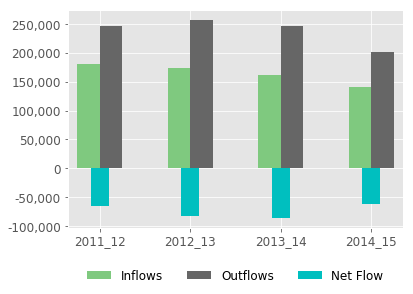

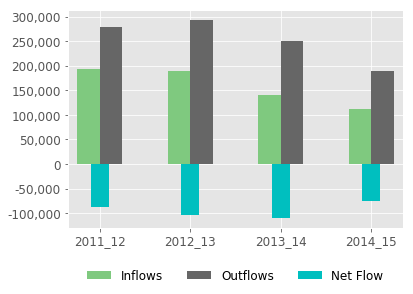

In [32]:
# plot each
pl1=plot_migration(total_city_dom, flowcolor3)
f=pl1.get_figure()
f.savefig(os.path.join(project_path, 'images','nyc_dom_yrly.png'),bbox_inches='tight')

#pl2=plot_migration(total_city_foreign, flowcolor3)
#f2=pl2.get_figure()
#f2.savefig(os.path.join(project_path, 'images','nyc_forgn_yrly.png'),bbox_inches='tight')

pl3=plot_migration(total_by_metro_dom, flowcolor3)
f3=pl3.get_figure()
f3.savefig(os.path.join(project_path, 'images','nyma_dom_yrly.png'),bbox_inches='tight')

In [33]:
# for cummulative, just sum the rows 
total_city_dom.sum()

in_migration     656,421
out_migration    952,613
net_migration   -296,192
dtype: int64

In [34]:
# put cummulative in one table 
cum_mig=pd.concat([total_city_dom.sum(),total_city_foreign.sum(),total_metro_dom.sum(), total_metro_foreign.sum()], axis=1)
cum_mig.columns=['domestic_mig_nyc','foreign_mig_nyc', 'domestic_mig_nyma','foreign_mig_nyma']
cum_mig

,domestic_mig_nyc,foreign_mig_nyc,domestic_mig_nyma,foreign_mig_nyma
in_migration,"656,421","20,568","904,138","39,894"
out_migration,"952,613","35,587","1,347,562","68,297"
net_migration,"-296,192","-15,019","-443,424","-28,403"


In [35]:
# format the table for output into latex document
cum_mig_latex=cum_mig[['domestic_mig_nyc','domestic_mig_nyma']].T
cum_mig_latex.rename(index={'domestic_mig_nyc':'New York City','domestic_mig_nyma':'New York Metro'}, 
                     columns={'in_migration':'In Flows','out_migration':'Out Flows','net_migration':'Net Flow'},inplace=True)

cum_mig_latex

,In Flows,Out Flows,Net Flow
New York City,"656,421","952,613","-296,192"
New York Metro,"904,138","1,347,562","-443,424"


In [36]:
cum_mig_latex.to_latex()

u'\\begin{tabular}{lrrr}\n\\toprule\n{} &  In Flows &  Out Flows &  Net Flow \\\\\n\\midrule\nNew York City  &   656,421 &    952,613 &  -296,192 \\\\\nNew York Metro &   904,138 &  1,347,562 &  -443,424 \\\\\n\\bottomrule\n\\end{tabular}\n'

## Top Places 

In [37]:
# number of top places
top = 10

In [38]:
# not all top places in one year remain top in other years
# these functions select places that were ranked 1-top in any of the 4-year period
def get_top_senders(df):
    all_time_top_senders = \
        df[
            (df['in_rank2011_12'] <= top) | (df['in_rank2012_13'] <= top) | (
                df['in_rank2013_14'] <= top) | (
                df['in_rank2014_15'] <= top)].copy()

    return all_time_top_senders
    
def get_top_receivers(df):    
    all_time_top_receivers = \
        df[
            (df['ou_rank2011_12'] <= top) | (df['ou_rank2012_13'] <= top) | (
                df['ou_rank2013_14'] <= top) | (df['ou_rank2014_15'] <= top)].copy()

    return all_time_top_receivers

In [39]:
# get top places for city 
top_senders_to_nyc=get_top_senders(domestic_city_flows)
top_senders_to_nyc['county'] = top_senders_to_nyc['co_name'] + "," + top_senders_to_nyc['state']
top_senders_to_nyc = top_senders_to_nyc.set_index ('county').drop (['co_name', 'state'], 1)

top_receivers_from_nyc=get_top_receivers(domestic_city_flows)
top_receivers_from_nyc['county'] = top_receivers_from_nyc['co_name'] + "," + top_receivers_from_nyc['state']
top_receivers_from_nyc = top_receivers_from_nyc.set_index ('county').drop (['co_name', 'state'], 1)

In [40]:
# get top senders/receivers for metro area
top_senders_to_nyma=get_top_senders(grouped_by_metro)
top_receivers_from_nyma=get_top_receivers(grouped_by_metro)

In [41]:
# look at the yearly migration from NYC to top receiving counties
top_receivers_from_nyc[['outflow2011_12','outflow2012_13','outflow2013_14','outflow2014_15']].sort_values(['outflow2011_12','outflow2012_13','outflow2013_14','outflow2014_15'], ascending=False)

,outflow2011_12,outflow2012_13,outflow2013_14,outflow2014_15
county,,,,
"Nassau County,NY","22,803","24,494","25,204","20,316"
"Westchester County,NY","16,967","18,414","17,173","13,986"
"Other flows - Different State,DS","16,808","17,381","25,405","23,807"
"Suffolk County,NY","9,785","9,636","9,271","8,171"
"Hudson County,NJ","8,761","9,141","8,818","7,273"
"Bergen County,NJ","7,687","7,977","7,124","5,816"
"Los Angeles County,CA","5,821","7,374","6,395","5,365"
"Fairfield County,CT","5,422","5,834","5,566","4,283"
"Essex County,NJ","5,180","5,536","5,819","4,791"


In [42]:
# look at the yearly migration to NYC from top sending counties
top_senders_to_nyc[['inflow2011_12','inflow2012_13','inflow2013_14','inflow2014_15']].sort_values(['inflow2011_12','inflow2012_13','inflow2013_14','inflow2014_15'], ascending=False)

,inflow2011_12,inflow2012_13,inflow2013_14,inflow2014_15
county,,,,
"Nassau County,NY","13,995","14,458","13,877","11,900"
"Other flows - Different State,DS","13,850","14,062","21,728","19,743"
"Westchester County,NY","11,588","10,806","10,438","9,048"
"Suffolk County,NY","8,838","7,493","7,056","5,837"
"Hudson County,NJ","6,308","6,270","5,729","4,709"
"Bergen County,NJ","5,393","4,436","4,315","3,860"
"Los Angeles County,CA","4,297","4,265","4,231","3,465"
"Miami-Dade County,FL","3,755","3,862","2,571","2,062"
"Essex County,NJ","3,536","3,114","2,996","2,861"


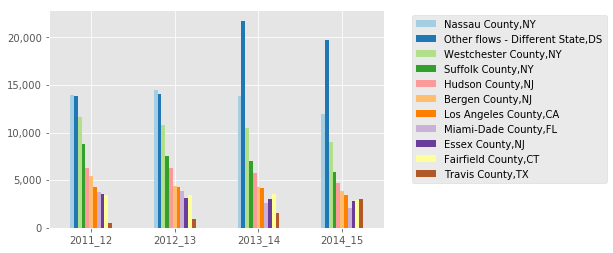

In [43]:
# look at the yearly migration to NYC from top sending counties
ax=top_senders_to_nyc[['inflow2011_12','inflow2012_13','inflow2013_14','inflow2014_15']].T.plot(kind='bar', rot=0, colormap='Paired')
ax.legend (bbox_to_anchor=(1.07, 1), loc='upper left')
ax.get_yaxis().set_major_formatter(plt.FuncFormatter(lambda x, loc: "{:,}".format(int(x))))
ax.set_xticklabels(years)
plt.show()

In [44]:
# yearly migration from NYMA to top receiving counties
top_receivers_from_nyma[['cbsa_name','outflow2011_12','outflow2012_13','outflow2013_14','outflow2014_15']].sort_values(['outflow2011_12','outflow2012_13','outflow2013_14','outflow2014_15'], ascending=False)

,cbsa_name,outflow2011_12,outflow2012_13,outflow2013_14,outflow2014_15
163,"Miami-Fort Lauderdale-West Palm Beach, FL","23,905","23,388","22,304","18,596"
195,"Philadelphia-Camden-Wilmington, PA-NJ-DE-MD","20,762","20,100","17,532","13,874"
38,"Bridgeport-Stamford-Norwalk, CT","11,486","12,518","12,205","9,683"
268,"Washington-Arlington-Alexandria, DC-VA-MD-WV","11,322","11,662","12,237","8,391"
152,"Los Angeles-Long Beach-Anaheim, CA","10,993","13,258","11,918","9,626"
11,"Atlanta-Sandy Springs-Roswell, GA","9,968","10,141","8,685","6,628"
33,"Boston-Cambridge-Newton, MA-NH","9,594","9,590","7,978","6,138"
188,"Orlando-Kissimmee-Sanford, FL","9,434","9,991","8,911","7,044"
4,"Allentown-Bethlehem-Easton, PA-NJ","8,676","8,032","7,727","6,069"
250,"Tampa-St. Petersburg-Clearwater, FL","7,462","7,759","7,182","5,675"


In [45]:
# yearly migration to NYMA from top sending counties
top_senders_to_nyma[['cbsa_name','inflow2011_12','inflow2012_13','inflow2013_14','inflow2014_15']].sort_values(['inflow2011_12','inflow2012_13','inflow2013_14','inflow2014_15'], ascending=False)

,cbsa_name,inflow2011_12,inflow2012_13,inflow2013_14,inflow2014_15
163,"Miami-Fort Lauderdale-West Palm Beach, FL","17,744","17,515","12,797","9,757"
195,"Philadelphia-Camden-Wilmington, PA-NJ-DE-MD","16,305","15,568","12,824","9,907"
268,"Washington-Arlington-Alexandria, DC-VA-MD-WV","9,053","9,350","7,689","7,660"
152,"Los Angeles-Long Beach-Anaheim, CA","8,482","8,595","7,946","6,196"
33,"Boston-Cambridge-Newton, MA-NH","8,305","8,495","6,940","5,001"
38,"Bridgeport-Stamford-Norwalk, CT","7,122","7,644","7,366","5,901"
11,"Atlanta-Sandy Springs-Roswell, GA","6,604","6,293","4,141","2,615"
4,"Allentown-Bethlehem-Easton, PA-NJ","6,393","5,629","4,065","3,288"
255,"Trenton, NJ","5,697","5,640","5,313","3,962"
188,"Orlando-Kissimmee-Sanford, FL","5,675","4,959","3,654","2,788"


In [46]:
def plot_ranks(df, cols, title):

    """function to plot change in ranks over time
    :param df: dataframe to plot
    :param cols: a list of colum ranks to plot 
    :param title: Tile to display
    """
    df_ranks=df[cols]
    df_ranks.columns = [col[-7:] if 'rank' in col else col for col in df_ranks.columns]
    ax = df_ranks.T.plot (colormap='Paired')
    ax.invert_yaxis ()
    ax.yaxis.set_major_locator (ticker.MaxNLocator (integer=True)) # display only whole numbers
    ax.legend (bbox_to_anchor=(1.07, 1), loc='upper left')
    ax.set_xlabel ('Year')
    ax.set_ylabel ('Rank')
    ax2 = ax.twinx () # get second y axis on the right
    ax2.yaxis.set_major_locator (ticker.MaxNLocator (integer=True))
    ax2.set_ylim (ax.get_ylim ())
    plt.title (title)
    plt.show ()

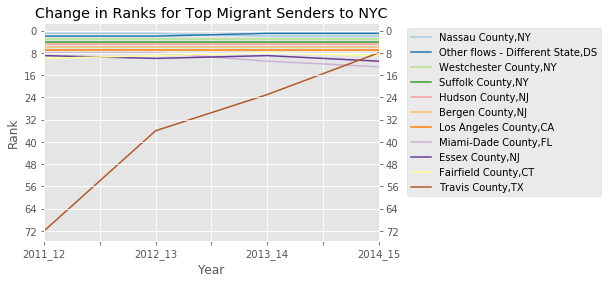

In [47]:
# plot change in ranks for top places that send migrants to NYC
plot_ranks (top_senders_to_nyc,['in_rank2011_12', 'in_rank2012_13', 'in_rank2013_14', 'in_rank2014_15'], 'Change in Ranks for Top Migrant Senders to NYC')

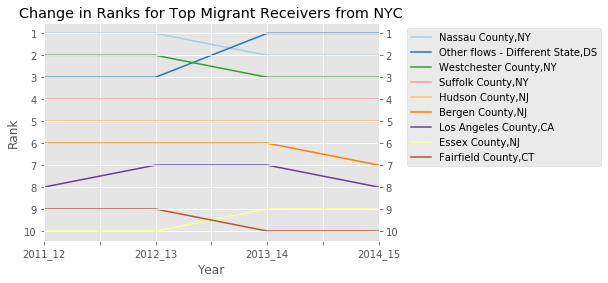

In [48]:
# plot change in ranks for top places that receive migrants from NYC
plot_ranks (top_receivers_from_nyc,['ou_rank2011_12', 'ou_rank2012_13', 'ou_rank2013_14', 'ou_rank2014_15'], 'Change in Ranks for Top Migrant Receivers from NYC')

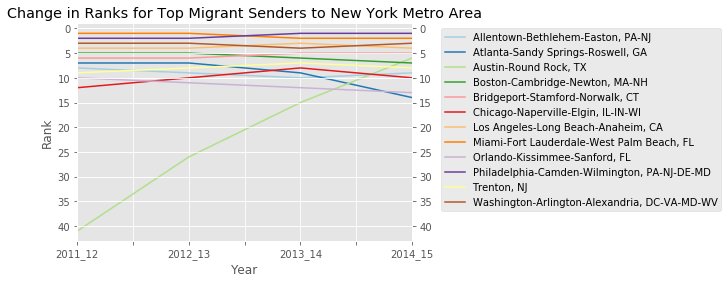

In [49]:
# same for NYMA
plot_ranks (top_senders_to_nyma.set_index('cbsa_name'),['in_rank2011_12', 'in_rank2012_13', 'in_rank2013_14', 'in_rank2014_15'], 'Change in Ranks for Top Migrant Senders to New York Metro Area')

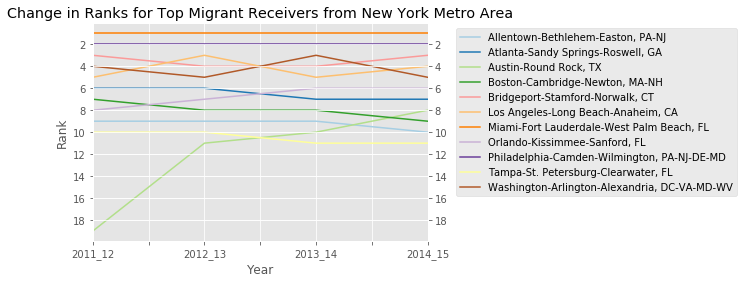

In [50]:
plot_ranks (top_receivers_from_nyma.set_index('cbsa_name'),['ou_rank2011_12', 'ou_rank2012_13', 'ou_rank2013_14', 'ou_rank2014_15'], 'Change in Ranks for Top Migrant Receivers from New York Metro Area')

## Deficit areas (negative net change) and Surpus Areas (positive net change)

The top deficit and surplus areas aren't same over the years. We can look at them one year at a time

In [51]:
# top surplus (send more to NYC than recieve from NYC) counties for 2011-2012
domestic_city_flows[['co_name','state','net_flow2011_12']].sort_values('net_flow2011_12', ascending=False).head(n=20)

,co_name,state,net_flow2011_12
17,District of Columbia,DC,368
24,Suffolk County,MA,221
84,Collier County,FL,124
19,Middlesex County,MA,101
173,Utah County,UT,99
43,Orange County,CA,79
119,Dane County,WI,70
104,Tompkins County,NY,67
136,Onslow County,NC,56
264,Clinton County,NY,49


In [52]:
# top deficit (receive more from NYC than send to NYC) counties for 2011-2012
domestic_city_flows[['co_name','state','net_flow2011_12']].sort_values('net_flow2011_12', ascending=True).head(n=20)

,co_name,state,net_flow2011_12
0,Nassau County,NY,"-8,808"
2,Westchester County,NY,"-5,379"
1,Other flows - Different State,DS,"-2,958"
4,Hudson County,NJ,"-2,453"
5,Bergen County,NJ,"-2,294"
9,Fairfield County,CT,"-2,010"
8,Essex County,NJ,"-1,644"
6,Los Angeles County,CA,"-1,524"
15,Broward County,FL,"-1,274"
25,Union County,NJ,"-1,215"


We can look at top places for cummulative (all 4 years) flows

In [53]:
domestic_city_flows['label']=domestic_city_flows['co_name']+', '+domestic_city_flows['state']

In [54]:
def plot_cum_top_places(df, col, label, color, title, n=20, high_to_low=True):
    if high_to_low:
        top_n=df[[col,label]].sort_values(col, ascending=False).head(n=n)
    else:
        top_n=df[[col,label]].sort_values(col, ascending=True).head(n=n)
    ax=top_n.set_index(label).plot(kind='barh', color=color, figsize=(8,6))
    ax.get_xaxis().set_major_formatter(plt.FuncFormatter(lambda x, loc: "{:,}".format(int(x))))
    ax.set_title(title)
    ax.set_ylabel('')
    plt.show()      

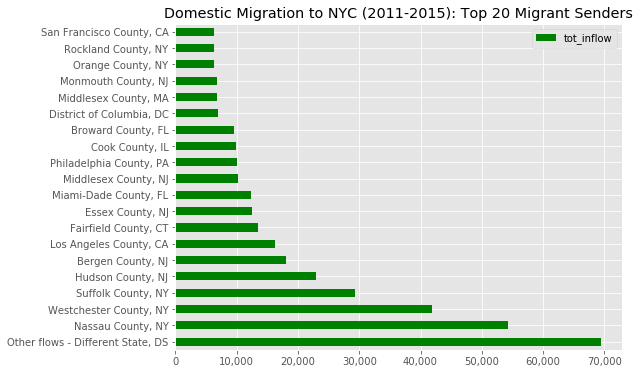

In [55]:
plot_cum_top_places(domestic_city_flows,'tot_inflow','label','green','Domestic Migration to NYC (2011-2015): Top 20 Migrant Senders')

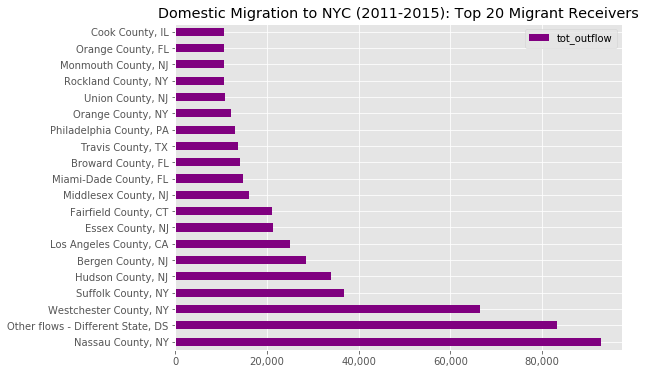

In [56]:
plot_cum_top_places(domestic_city_flows,'tot_outflow','label','purple','Domestic Migration to NYC (2011-2015): Top 20 Migrant Receivers')

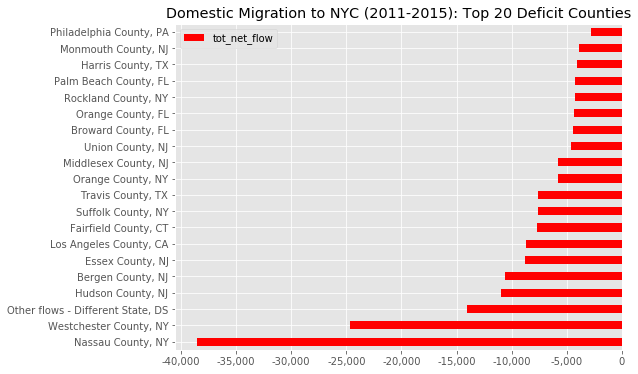

In [57]:
plot_cum_top_places(domestic_city_flows,'tot_net_flow','label','red','Domestic Migration to NYC (2011-2015): Top 20 Deficit Counties', high_to_low=False)

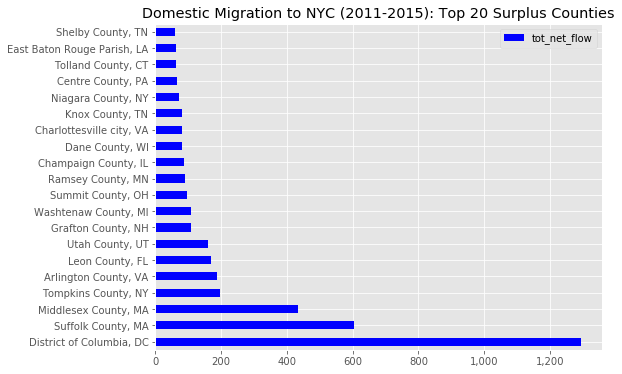

In [58]:
plot_cum_top_places(domestic_city_flows,'tot_net_flow','label','blue','Domestic Migration to NYC (2011-2015): Top 20 Surplus Counties')

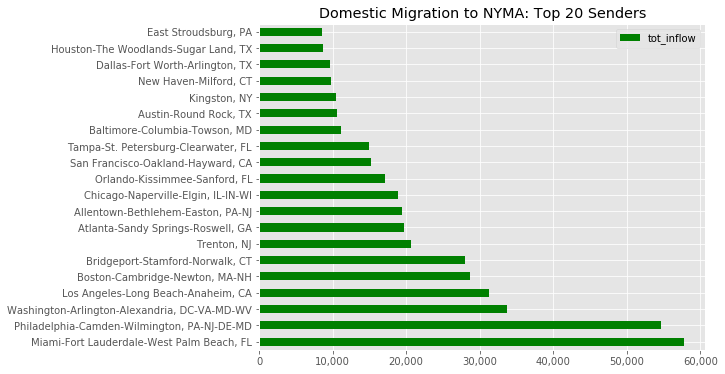

In [59]:
plot_cum_top_places(grouped_by_metro.reset_index(),'tot_inflow','cbsa_name','green','Domestic Migration to NYMA: Top 20 Senders')

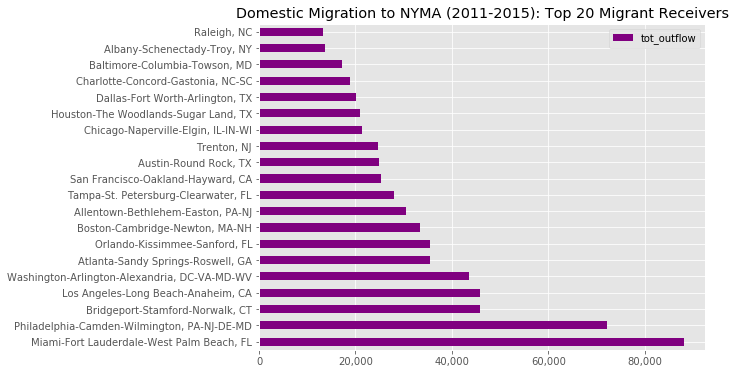

In [60]:
plot_cum_top_places(grouped_by_metro.reset_index(),'tot_outflow','cbsa_name','purple','Domestic Migration to NYMA (2011-2015): Top 20 Migrant Receivers')

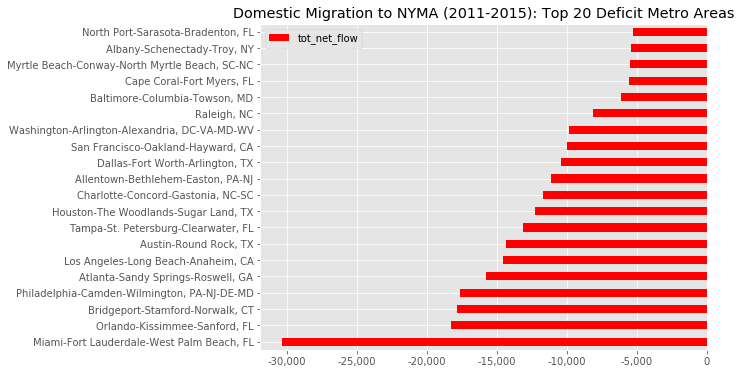

In [61]:
plot_cum_top_places(grouped_by_metro.reset_index(),'tot_net_flow','cbsa_name','red','Domestic Migration to NYMA (2011-2015): Top 20 Deficit Metro Areas', high_to_low=False)

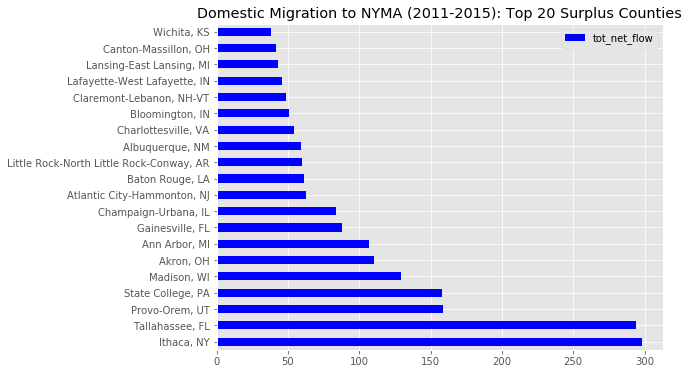

In [62]:
plot_cum_top_places(grouped_by_metro.reset_index(),'tot_net_flow','cbsa_name','blue','Domestic Migration to NYMA (2011-2015): Top 20 Surplus Counties')

## Net Totals Tables

In [63]:
domestic_city_flows.sort_values(by='tot_net_flow',inplace=True)
citytop20net=domestic_city_flows[domestic_city_flows.co_fips != '59000'][['label','tot_net_flow']].head(n=20)
citytop20net.set_index('label',inplace=True)
print(citytop20net.to_latex())

\begin{tabular}{lr}
\toprule
{} &  tot\_net\_flow \\
label                   &               \\
\midrule
Nassau County, NY       &       -38,587 \\
Westchester County, NY  &       -24,660 \\
Hudson County, NJ       &       -10,977 \\
Bergen County, NJ       &       -10,600 \\
Essex County, NJ        &        -8,819 \\
Los Angeles County, CA  &        -8,697 \\
Fairfield County, CT    &        -7,708 \\
Suffolk County, NY      &        -7,639 \\
Travis County, TX       &        -7,620 \\
Orange County, NY       &        -5,840 \\
Middlesex County, NJ    &        -5,758 \\
Union County, NJ        &        -4,602 \\
Broward County, FL      &        -4,457 \\
Orange County, FL       &        -4,371 \\
Rockland County, NY     &        -4,245 \\
Palm Beach County, FL   &        -4,228 \\
Harris County, TX       &        -4,095 \\
Monmouth County, NJ     &        -3,862 \\
Philadelphia County, PA &        -2,842 \\
Ocean County, NJ        &        -2,775 \\
\bottomrule
\end{tabular}



In [64]:
citybot10net=domestic_city_flows[['label','tot_net_flow']].tail(n=10)
citybot10net.set_index('label',inplace=True)
citybot10net.sort_values(by='tot_net_flow', ascending=False, inplace=True)
print(citybot10net.to_latex())

\begin{tabular}{lr}
\toprule
{} &  tot\_net\_flow \\
label                    &               \\
\midrule
District of Columbia, DC &         1,293 \\
Suffolk County, MA       &           604 \\
Middlesex County, MA     &           435 \\
Tompkins County, NY      &           197 \\
Arlington County, VA     &           187 \\
Leon County, FL          &           168 \\
Utah County, UT          &           159 \\
Grafton County, NH       &           108 \\
Washtenaw County, MI     &           107 \\
Summit County, OH        &            97 \\
\bottomrule
\end{tabular}



In [65]:
grouped_by_metro.sort_values(by='tot_net_flow',inplace=True)
metrotop20net=grouped_by_metro[['cbsa_name','tot_net_flow']].head(n=20)
metrotop20net.set_index('cbsa_name',inplace=True)
print(metrotop20net.to_latex())

\begin{tabular}{lr}
\toprule
{} &  tot\_net\_flow \\
cbsa\_name                                     &               \\
\midrule
Miami-Fort Lauderdale-West Palm Beach, FL     &       -30,380 \\
Orlando-Kissimmee-Sanford, FL                 &       -18,304 \\
Bridgeport-Stamford-Norwalk, CT               &       -17,859 \\
Philadelphia-Camden-Wilmington, PA-NJ-DE-MD   &       -17,664 \\
Atlanta-Sandy Springs-Roswell, GA             &       -15,769 \\
Los Angeles-Long Beach-Anaheim, CA            &       -14,576 \\
Austin-Round Rock, TX                         &       -14,368 \\
Tampa-St. Petersburg-Clearwater, FL           &       -13,151 \\
Houston-The Woodlands-Sugar Land, TX          &       -12,273 \\
Charlotte-Concord-Gastonia, NC-SC             &       -11,732 \\
Allentown-Bethlehem-Easton, PA-NJ             &       -11,129 \\
Dallas-Fort Worth-Arlington, TX               &       -10,421 \\
San Francisco-Oakland-Hayward, CA             &       -10,025 \\
Washington-Arlington-Alexan

In [66]:
metrobot10net=grouped_by_metro[['cbsa_name','tot_net_flow']].tail(n=10)
metrobot10net.set_index('cbsa_name',inplace=True)
metrobot10net.sort_values(by='tot_net_flow', ascending=False, inplace=True)
print(metrobot10net.to_latex())

\begin{tabular}{lr}
\toprule
{} &  tot\_net\_flow \\
cbsa\_name                   &               \\
\midrule
Ithaca, NY                  &           298 \\
Tallahassee, FL             &           294 \\
Provo-Orem, UT              &           159 \\
State College, PA           &           158 \\
Madison, WI                 &           129 \\
Akron, OH                   &           110 \\
Ann Arbor, MI               &           107 \\
Gainesville, FL             &            88 \\
Champaign-Urbana, IL        &            84 \\
Atlantic City-Hammonton, NJ &            63 \\
\bottomrule
\end{tabular}



## Urban Suburban Status

In [67]:
# function to label counties in metro as 'suburban' and others as 'distant'
def is_suburban(col, metro):
    if col in metro:
        return 'suburban'
    else:
        return 'distant'

In [68]:
domestic_city_flows['cnty_status']=domestic_city_flows.co_fips.apply(lambda x: is_suburban(x, nyma))

In [69]:
by_status=domestic_city_flows[['cnty_status','inflow2011_12','inflow2012_13',
                               'inflow2013_14','inflow2014_15',
                              'outflow2011_12','outflow2012_13',
                               'outflow2013_14','outflow2014_15']].groupby('cnty_status').sum()

In [70]:
by_status['pct_dif_inflow']=(by_status['inflow2014_15']-by_status['inflow2011_12'])/by_status['inflow2011_12']*100
by_status['pct_dif_outflow']=(by_status['outflow2014_15']-by_status['outflow2011_12'])/by_status['outflow2011_12']*100
by_status['tot_inflow']=by_status[['inflow2011_12','inflow2012_13',
                               'inflow2013_14','inflow2014_15']].sum(axis=1)
by_status['tot_outflow']=by_status[['outflow2011_12','outflow2012_13',
                               'outflow2013_14','outflow2014_15']].sum(axis=1)

In [71]:
by_status

,inflow2011_12,inflow2012_13,inflow2013_14,inflow2014_15,outflow2011_12,outflow2012_13,outflow2013_14,outflow2014_15,pct_dif_inflow,pct_dif_outflow,tot_inflow,tot_outflow
cnty_status,,,,,,,,,,,,
distant,"114,733","112,531","103,212","89,572","150,765","156,652","149,882","122,391",-22,-19,"420,048","579,690"
suburban,"65,726","61,282","58,540","50,825","95,121","100,404","97,525","79,873",-23,-16,"236,373","372,923"


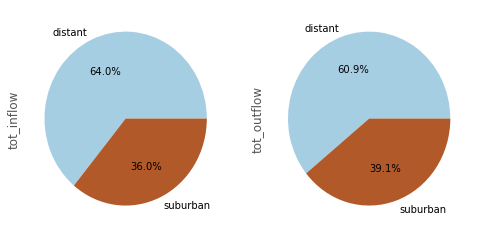

In [72]:
# inflows and outflows to NYC from suburban counties accounted for more than third of all domestic NYC flows 
ax=by_status[['tot_inflow','tot_outflow']].plot.pie(subplots=True, legend=False, autopct='%1.1f%%',figsize=(8,4),colormap='Paired')

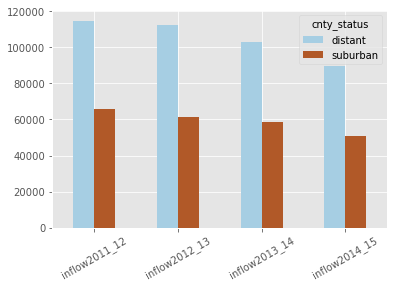

In [73]:
# yearly change in inflows to NYC for suburban and distant counties
by_status[['inflow2011_12','inflow2012_13',
                               'inflow2013_14','inflow2014_15']].T.plot(kind='bar', rot=30, colormap='Paired')

## Top Places in one table

Most of the top senders to NYC/NYMA are also top receivers from NYC/NYMA. We can look at them in a single table/chart.

In [74]:
domestic_city_flows.set_index('co_fips', inplace=True)

In [75]:
# get the list of top sending/receiving counties
top_inflows=domestic_city_flows['tot_inflow'].sort_values(ascending=False).head(n=16)
top_outflows=domestic_city_flows['tot_outflow'].sort_values(ascending=False).head(n=16)
counties_for_plot=top_inflows.index.tolist()
counties_for_plot.extend(top_outflows.index.tolist())

In [76]:
counties_for_plot=set(counties_for_plot)
# some places only appear in only one of the tables--we end up with more than 16 places
len(counties_for_plot)

19

In [77]:
df_to_plot=domestic_city_flows.loc[counties_for_plot,['label','tot_inflow','tot_outflow']]
df_to_plot.sort_values(by='tot_outflow',ascending=False, inplace=True)
df_to_plot

,label,tot_inflow,tot_outflow
co_fips,,,
36059,"Nassau County, NY","54,230","92,817"
59000,"Other flows - Different State, DS","69,383","83,401"
36119,"Westchester County, NY","41,880","66,540"
36103,"Suffolk County, NY","29,224","36,863"
34017,"Hudson County, NJ","23,016","33,993"
34003,"Bergen County, NJ","18,004","28,604"
06037,"Los Angeles County, CA","16,258","24,955"
34013,"Essex County, NJ","12,507","21,326"
09001,"Fairfield County, CT","13,397","21,105"


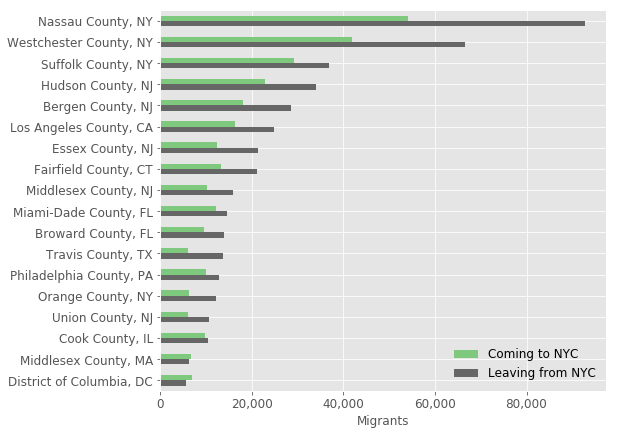

In [78]:
# drop Other flows-Different State and plot
axc=df_to_plot.drop('59000').set_index('label').plot(kind='barh',figsize=(8,7), color=flowcolor2)
axc.legend(['Coming to NYC','Leaving from NYC'], loc='best',fontsize=12, frameon=False)
axc.invert_yaxis()
axc.set_ylabel('')
axc.set_xlabel('Migrants')
axc.get_xaxis().set_major_formatter(plt.FuncFormatter(lambda x, loc: "{:,}".format(int(x))))

# ticks labels size
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()
nyc_fig=axc.get_figure()
nyc_fig.savefig(os.path.join(project_path, 'images','nyc_top_flow.png'),bbox_inches='tight')

In [79]:
grouped_by_metro.set_index('cbsa_code', inplace=True)
top_m_inflows=grouped_by_metro['tot_inflow'].sort_values(ascending=False).head(n=15)
top_m_outflows=grouped_by_metro['tot_outflow'].sort_values(ascending=False).head(n=15)
metros_for_plot=top_m_inflows.index.tolist()
metros_for_plot.extend(top_m_outflows.index.tolist())
metros_for_plot=set(metros_for_plot)
# some places only appear in only one of the tables--we end up with more than 15 places 
len(metros_for_plot)

16

In [80]:
dfm_to_plot=grouped_by_metro.loc[metros_for_plot,['cbsa_name','tot_inflow','tot_outflow']]
dfm_to_plot.sort_values(by='tot_outflow',ascending=False, inplace=True)
dfm_to_plot

,cbsa_name,tot_inflow,tot_outflow
cbsa_code,,,
33100,"Miami-Fort Lauderdale-West Palm Beach, FL","57,813","88,193"
37980,"Philadelphia-Camden-Wilmington, PA-NJ-DE-MD","54,604","72,268"
14860,"Bridgeport-Stamford-Norwalk, CT","28,033","45,892"
31080,"Los Angeles-Long Beach-Anaheim, CA","31,219","45,795"
47900,"Washington-Arlington-Alexandria, DC-VA-MD-WV","33,752","43,612"
12060,"Atlanta-Sandy Springs-Roswell, GA","19,653","35,422"
36740,"Orlando-Kissimmee-Sanford, FL","17,076","35,380"
14460,"Boston-Cambridge-Newton, MA-NH","28,741","33,300"
10900,"Allentown-Bethlehem-Easton, PA-NJ","19,375","30,504"


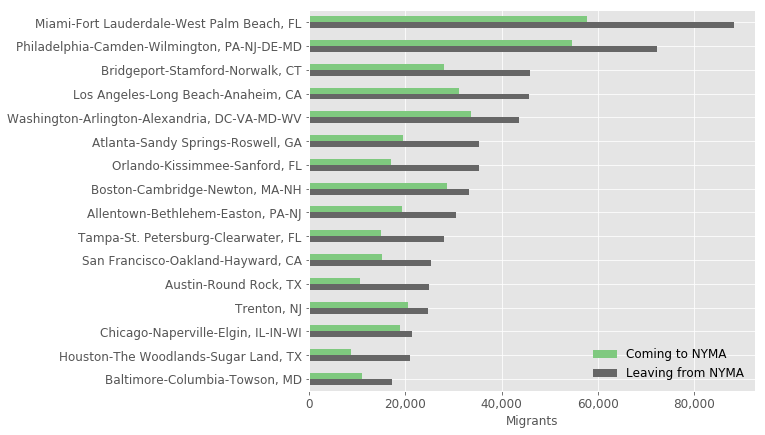

In [81]:
axm=dfm_to_plot.set_index('cbsa_name').plot(kind='barh',figsize=(8,7),color=flowcolor2)
axm.legend(['Coming to NYMA','Leaving from NYMA',], loc='best',fontsize=12, frameon=False)
axm.set_ylabel('')
axm.invert_yaxis()
axm.set_xlabel('Migrants')
axm.get_xaxis().set_major_formatter(plt.FuncFormatter(lambda x, loc: "{:,}".format(int(x))))

# ticks labels size
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()
nyma_fig=axm.get_figure()
nyma_fig.savefig(os.path.join(project_path, 'images','nyma_top_flow.png'),bbox_inches='tight')

## Comparison with other big cities and metros

Compare cumulative flows for selected big (population over 1M ) cities

In [82]:
# empty list to hold the records of the dataframe we'll build from querying the database
df_lines=[]

In [83]:
# get cumulative total domestic inflows and outflows for big cities
for cnty in big_cities.keys():
    
    # exclude NYC: it consists of multiple counties and we already have the data
    if cnty not in nyc:        
        # yearly outflows
        all_outs=[]        
        # yearly inflows
        all_ins=[]        
        for year in years:
            table1 = 'outflow_{}'.format (year)
            table2 = 'inflow_{}'.format (year)

            cur.execute("SELECT SUM (exemptions) as outflow{0} from {1} where {2}.origin='{3}' and {4}.destination!='{5}' and {6}.destination not in {7} ".format (year, table1,  table1, cnty, table1, cnty, table1, foreign))    
            outs=cur.fetchone()[0]

            cur.execute("SELECT SUM (exemptions) as inflow{0} from {1} where {2}.origin!='{3}' and {4}.destination='{5}' and {6}.origin not in {7} ".format (year, table2, table2, cnty, table2, cnty, table2, foreign))    
            ins=cur.fetchone()[0]
            
            all_outs.append(outs)
            all_ins.append(ins)
        # sum yearly data
        total_out=sum(all_outs)
        total_in=sum(all_ins)
        df_line=(cnty,total_in,total_out)
        df_lines.append(df_line)

In [84]:
# create a dataframe from the list 
df_cities=pd.DataFrame(df_lines, columns=['county','tot_inflow','tot_outflow'])
df_cities['tot_net_flow']=df_cities['tot_inflow']-df_cities['tot_outflow']

In [85]:
# add city names column
city_names=pd.DataFrame.from_dict(big_cities, orient='index')
df_cities=df_cities.merge(city_names, left_on='county', right_index=True, how='left').rename(columns={0:'city_name'})

In [86]:
# append NYC records
nyc_tot=pd.DataFrame(domestic_city_flows[['tot_inflow','tot_outflow','tot_net_flow']].sum()).T
nyc_tot['city_name']='New York City, NY'
df_cities=df_cities.append(nyc_tot)

In [87]:
# reorder columns; remove county column
df_cities=df_cities[['city_name','tot_inflow','tot_outflow','tot_net_flow']]
df_cities.sort_values(by='tot_net_flow',ascending=False, inplace=True)
df_cities

,city_name,tot_inflow,tot_outflow,tot_net_flow
4,"Maricopa Co, AZ (Phoenix)","537,450","467,531","69,919"
3,"Bexar Co, TX (San Antonio)","292,490","253,215","39,275"
8,"Harris Co, TX (Houston)","641,799","605,881","35,918"
1,"Dallas Co, TX","465,353","478,406","-13,053"
5,"San Diego Co, CA","425,183","441,060","-15,877"
2,"Santa Clara Co, CA (San Jose)","238,679","269,354","-30,675"
7,"Philadelphia Co, PA","168,927","210,259","-41,332"
0,"Cook Co, IL (Chicago)","483,007","631,779","-148,772"
6,"Los Angeles Co, CA","775,012","956,811","-181,799"
0,"New York City, NY","656,421","952,613","-296,192"


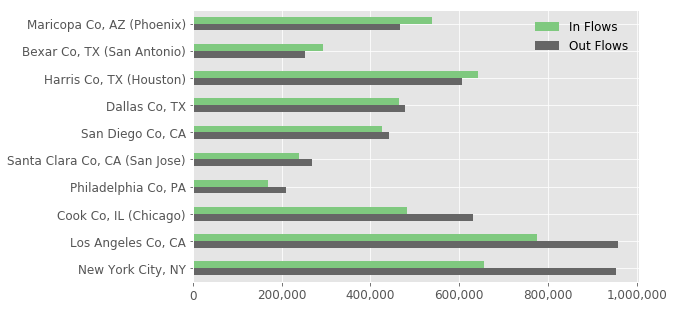

In [88]:
# plot domestic migration for 10 big cities
axbc=df_cities[['city_name','tot_inflow','tot_outflow']].set_index('city_name').plot(kind='barh', figsize=(8,5), color=flowcolor2)
axbc.legend(['In Flows','Out Flows'], fontsize=12, frameon=False)
axbc.invert_yaxis()              
axbc.get_xaxis().set_major_formatter(plt.FuncFormatter(lambda x, loc: "{:,}".format(int(x))))
axbc.set_ylabel('')
# ticks labels size
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()
big_c_fig=axbc.get_figure()
big_c_fig.savefig(os.path.join(project_path, 'images','big_cities_dom.png'),bbox_inches='tight')

Compare cumulative flows for selected largest metros

In [128]:
mdf_lines=[]

In [129]:
# running this cell takes awhile
import time
start = time.time()

for m in big_metros:
    all_outs=[]
    all_ins=[]
    for year in years:
        
        table1 = 'outflow_{}'.format (year)
        table2 = 'inflow_{}'.format (year)
        
        outflows=pd.read_sql_query ("SELECT * from {} where {}.origin!={}.destination".format (table1, table1, table1), con)
        
        outflows=outflows.merge(metros[['cbsa_code', 'cbsa_name', 'fips']], left_on='origin', right_on='fips',
                                   how='left').drop ('fips', 1).rename(columns={'cbsa_name':'cbsa_orig_name',
                                                                                'cbsa_code':'cbsa_orig'})
        outflows=outflows.merge(metros[['cbsa_code', 'cbsa_name', 'fips']], left_on='destination', right_on='fips',
                                   how='left').drop ('fips', 1).rename(columns={'cbsa_name':'cbsa_dest_name',
                                                                                'cbsa_code':'cbsa_dest'})
        
        inflows=pd.read_sql_query ("SELECT * from {} where {}.origin!={}.destination".format (table2, table2, table2), con)
        
        inflows=inflows.merge(metros[['cbsa_code', 'cbsa_name', 'fips']], left_on='origin', right_on='fips',
                                   how='left').drop ('fips', 1).rename(columns={'cbsa_name':'cbsa_orig_name',
                                                                                'cbsa_code':'cbsa_orig'})
        inflows=inflows.merge(metros[['cbsa_code', 'cbsa_name', 'fips']], left_on='destination', right_on='fips',
                                   how='left').drop ('fips', 1).rename(columns={'cbsa_name':'cbsa_dest_name',
                                                                                'cbsa_code':'cbsa_dest'})
        
        # select & sum flows from counties that are not in the same metro and are not foreign
        tot_out=outflows.loc[(outflows['cbsa_orig']==m) & (outflows['cbsa_dest']!=m) & (~outflows['destination'].isin(foreign)), 'exemptions'].sum()
        
        # select & sum flows to metro from counties that are not in the same metro and are not foreign
        tot_in=inflows.loc[(inflows['cbsa_orig']!=m) & (inflows['cbsa_dest']==m) & (~inflows['origin'].isin(foreign)), 'exemptions'].sum()
        
        all_outs.append(tot_out)
        all_ins.append(tot_in)
        
    total_out=sum(all_outs)
    total_in=sum(all_ins)
    df_line=(m,total_in,total_out)
    mdf_lines.append(df_line)
    
end = time.time()
print(int(end - start), 'seconds passed')

(66, 'seconds passed')


In [130]:
mdf_lines

[('35620', 904138.0, 1347562.0),
 ('31080', 917234.0, 1119864.0),
 ('16980', 530860.0, 712153.0),
 ('19100', 790234.0, 648581.0),
 ('26420', 682522.0, 517289.0),
 ('47900', 674302.0, 733947.0),
 ('37980', 396262.0, 452813.0),
 ('33100', 600886.0, 661501.0),
 ('12060', 741799.0, 675367.0),
 ('14460', 371199.0, 408002.0),
 ('41860', 519044.0, 494506.0),
 ('38060', 544692.0, 460729.0),
 ('40140', 606727.0, 567250.0),
 ('19820', 275807.0, 314555.0)]

In [131]:
df_metros=pd.DataFrame(mdf_lines, columns=['cbsa','tot_inflow','tot_outflow'])
df_metros['tot_net_flow']=df_metros['tot_inflow']-df_metros['tot_outflow']
df_metros

,cbsa,tot_inflow,tot_outflow,tot_net_flow
0,35620,"904,138","1,347,562","-443,424"
1,31080,"917,234","1,119,864","-202,630"
2,16980,"530,860","712,153","-181,293"
3,19100,"790,234","648,581","141,653"
4,26420,"682,522","517,289","165,233"
5,47900,"674,302","733,947","-59,645"
6,37980,"396,262","452,813","-56,551"
7,33100,"600,886","661,501","-60,615"
8,12060,"741,799","675,367","66,432"
9,14460,"371,199","408,002","-36,803"


In [132]:
# add metro names to cbsa codes and merge
metro_names=metros[['cbsa_name','cbsa_code']].drop_duplicates()
df_metros=df_metros.merge(metro_names, left_on='cbsa', right_on='cbsa_code').drop('cbsa_code',1)
df_metros.sort_values(by='tot_net_flow', ascending=False, inplace=True)
df_metros

,cbsa,tot_inflow,tot_outflow,tot_net_flow,cbsa_name
4,26420,"682,522","517,289","165,233","Houston-The Woodlands-Sugar Land, TX"
3,19100,"790,234","648,581","141,653","Dallas-Fort Worth-Arlington, TX"
11,38060,"544,692","460,729","83,963","Phoenix-Mesa-Scottsdale, AZ"
8,12060,"741,799","675,367","66,432","Atlanta-Sandy Springs-Roswell, GA"
12,40140,"606,727","567,250","39,477","Riverside-San Bernardino-Ontario, CA"
10,41860,"519,044","494,506","24,538","San Francisco-Oakland-Hayward, CA"
9,14460,"371,199","408,002","-36,803","Boston-Cambridge-Newton, MA-NH"
13,19820,"275,807","314,555","-38,748","Detroit-Warren-Dearborn, MI"
6,37980,"396,262","452,813","-56,551","Philadelphia-Camden-Wilmington, PA-NJ-DE-MD"
5,47900,"674,302","733,947","-59,645","Washington-Arlington-Alexandria, DC-VA-MD-WV"


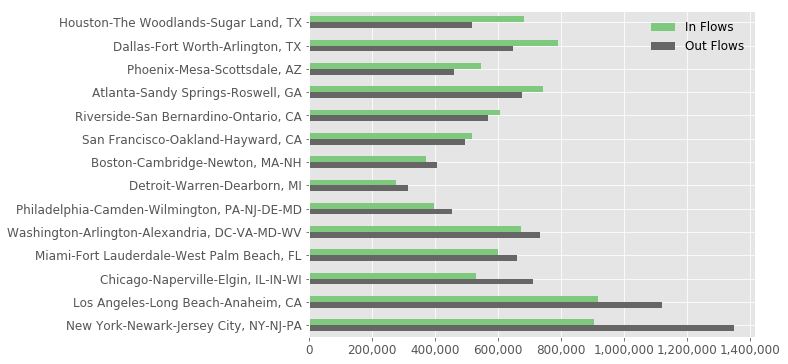

In [133]:
# plot domestic migration for big metros
axbm=df_metros[['cbsa_name','tot_inflow','tot_outflow']].set_index('cbsa_name').plot(kind='barh', figsize=(8,6), color=flowcolor2)
axbm.legend(['In Flows','Out Flows'], fontsize=12, frameon=False)
axbm.get_xaxis().set_major_formatter(plt.FuncFormatter(lambda x, loc: "{:,}".format(int(x))))
axbm.invert_yaxis() 
axbm.set_ylabel('')
# ticks labels size
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()
big_m_fig=axbm.get_figure()
big_m_fig.savefig(os.path.join(project_path, 'images','big_metros_dom.png'),bbox_inches='tight')

## Los Angeles

Quick loook at Los Angeles City and LA metro area flows

In [134]:
la=['06037']
lama=('06037','06059')

In [135]:
la_flows_dfs=[]
lama_flows_dfs=[]

In [136]:
for year in years:
    la_flows_dfs.append (get_flows_by_city (year, la))

for year in years:
    lama_flows_dfs.append (get_flows_by_city (year, lama))

# merge all years dfs for LA (LAMA) from the list into a single df
la_flows=reduce(lambda x, y: pd.merge(x, y, on = ['co_fips', 'co_name', 'state', 'cbsa_code', 'cbsa_name'], how='outer'), la_flows_dfs)
lama_flows=reduce(lambda x, y: pd.merge(x, y, on = ['co_fips', 'co_name', 'state', 'cbsa_code', 'cbsa_name'], how='outer'), lama_flows_dfs)

In [137]:
la_flows.head()

,co_fips,co_name,state,inflow2011_12,outflow2011_12,cbsa_code,cbsa_name,net_flow2011_12,inflow2012_13,outflow2012_13,net_flow2012_13,inflow2013_14,outflow2013_14,net_flow2013_14,inflow2014_15,outflow2014_15,net_flow2014_15
0,06059,Orange County,CA,"30,298","37,081",31080,"Los Angeles-Long Beach-Anaheim, CA","-6,783","32,180","37,902","-5,722","28,931","35,528","-6,597","23,411","28,238","-4,827"
1,06071,San Bernardino County,CA,"28,641","40,010",40140,"Riverside-San Bernardino-Ontario, CA","-11,369","27,414","39,172","-11,758","23,634","35,602","-11,968","19,339","30,386","-11,047"
2,06065,Riverside County,CA,"15,565","21,758",40140,"Riverside-San Bernardino-Ontario, CA","-6,193","14,967","22,447","-7,480","13,274","19,877","-6,603","10,284","15,802","-5,518"
3,06073,San Diego County,CA,"8,982","9,834",41740,"San Diego-Carlsbad, CA",-852,"8,989","10,322","-1,333","8,309","8,986",-677,"6,535","8,130","-1,595"
4,06111,Ventura County,CA,"8,593","10,502",37100,"Oxnard-Thousand Oaks-Ventura, CA","-1,909","8,195","11,280","-3,085","7,665","10,020","-2,355","6,195","7,922","-1,727"


In [138]:
# get subsets of domestic flows 
domestic_la_flows=la_flows[~la_flows['co_fips'].isin (foreign)].copy()

#group by metro area to get metro to metro flows
lama_by_metro=lama_flows.groupby(['cbsa_name','cbsa_code']).sum().reset_index()

In [139]:
# add cummulative numbers for inflow, outflow, netflow for city and metro 
# these are totals for all 4 years
domestic_la_flows['tot_inflow']=domestic_la_flows[['inflow2011_12','inflow2012_13',
                               'inflow2013_14','inflow2014_15']].sum(axis=1)

domestic_la_flows['tot_outflow']=domestic_la_flows[['outflow2011_12','outflow2012_13',
                               'outflow2013_14','outflow2014_15']].sum(axis=1)

domestic_la_flows['tot_net_flow']=domestic_la_flows['tot_inflow']-domestic_la_flows['tot_outflow']

In [140]:
domestic_la_flows['label']=domestic_la_flows['co_name']+', '+domestic_la_flows['state']

In [141]:
lama_by_metro['tot_inflow']=lama_by_metro[['inflow2011_12','inflow2012_13',
                               'inflow2013_14','inflow2014_15']].sum(axis=1)

lama_by_metro['tot_outflow']=lama_by_metro[['outflow2011_12','outflow2012_13',
                               'outflow2013_14','outflow2014_15']].sum(axis=1)

lama_by_metro['tot_net_flow']=lama_by_metro['tot_inflow']-lama_by_metro['tot_outflow']

In [142]:
domestic_la_flows[['label','tot_inflow','tot_outflow','tot_net_flow']].sort_values(by='tot_net_flow',ascending=False).head(n=30)

,label,tot_inflow,tot_outflow,tot_net_flow
9,"New York County, NY","12,735","8,605","4,130"
10,"Cook County, IL","10,401","6,782","3,619"
19,"Kings County, NY","7,006","4,352","2,654"
26,"Queens County, NY","4,004","2,527","1,477"
22,"Miami-Dade County, FL","5,020","4,225",795
56,"Suffolk County, MA","1,915","1,161",754
70,"Hudson County, NJ","1,706",990,716
57,"Philadelphia County, PA","1,936","1,270",666
64,"Nassau County, NY","1,641","1,077",564
36,"Middlesex County, MA","2,858","2,304",554


In [143]:
lama_by_metro[['cbsa_name','tot_inflow','tot_outflow','tot_net_flow']].sort_values(by='tot_net_flow',ascending=False).head(n=30)

,cbsa_name,tot_inflow,tot_outflow,tot_net_flow
294,"New York-Newark-Jersey City, NY-NJ-PA","45,795","31,219","14,576"
78,"Chicago-Naperville-Elgin, IL-IN-WI","19,716","13,411","6,305"
47,"Boston-Cambridge-Newton, MA-NH","9,239","7,005","2,234"
319,"Philadelphia-Camden-Wilmington, PA-NJ-DE-MD","7,237","5,060","2,177"
266,"Miami-Fort Lauderdale-West Palm Beach, FL","12,353","10,688","1,665"
442,"Washington-Arlington-Alexandria, DC-VA-MD-WV","14,130","13,000","1,130"
270,"Minneapolis-St. Paul-Bloomington, MN-WI","5,202","4,228",974
28,"Baltimore-Columbia-Towson, MD","3,580","2,752",828
111,"Detroit-Warren-Dearborn, MI","5,065","4,272",793
176,"Hartford-West Hartford-East Hartford, CT","1,472",931,541
